In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

In [2]:
freqs = [5, 11, 20, 30, 40, 50, 60]
bias_by_freq = [-0.3, -0.359, -0.48, -0.628, -0.83, -1.037, -1.2]

def get_bias(hall_freq):
    """
    Finds the closest frequency in the list and returns the associated bias
    """
    closest = min(freqs, key=lambda x: abs(x-hall_freq))
    return bias_by_freq[freqs.index(closest)]

In [3]:
# Define the low pass filter
cutoff_freq = 0.09
sampling_freq = 1

def lowpass_filter(dataframe):
    b, a = butter(5, 2*cutoff_freq/sampling_freq, btype='low', analog=False)
    return filtfilt(b, a, dataframe)

In [4]:
def analyse(file_path, nolimit=False):

    df = pd.read_csv(file_path).iloc[50:-50]
    df['time'] = df.index
    df['sensor'] = df['Timestamp (unix time nano seconds)'].str.replace(' ', '')
    df = df[['time', 'sensor']]
    df = df.reset_index(drop=True)

    # Remove double counts on Omega
    previous_omega_index = -10
    for index, row in df[df.sensor=='Omega'].iterrows():
        if index-previous_omega_index < 5:
            print('Dropped one row.')
            df.drop(index, inplace=True)
        previous_omega_index = index        

    # Crop between the first and last Omega ticks
    first_omega_tick = list(df[df.sensor=='Omega'].index)[0]
    last_omega_tick = list(df[df.sensor=='Omega'].index)[-1]
    df = df.iloc[first_omega_tick+1:last_omega_tick+1]

    # Count the number of Omega ticks to find number of gallons
    gallons = len(df[df.sensor=='Omega'])*0.1

    # Get the number of gallons per tick using the Hall sensor
    hall_gallons_per_tick = gallons / len(df[df.sensor=='Hall'])
    
    # Compute GPMs
    omega_times = list(df[df.sensor=='Omega'].time)
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(omega_times)-1):
        frequency = 1/(omega_times[i+1]-omega_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'omega_freq'] = frequency
            df.loc[df.time>=0, 'omega_GPM'] = 0.1*frequency*60
        df.loc[df.time>=omega_times[i], 'omega_freq'] = frequency
        df.loc[df.time>=omega_times[i], 'omega_GPM'] = 0.1*frequency*60

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency/2
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
            df.loc[df.time>=0, 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_GPM_gpt'] = hall_gallons_per_tick*frequency*60

    # Remove errors
    df.loc[df['hall_GPM'] > 10, 'hall_GPM'] = np.nan
    df.loc[df['omega_GPM'] > 10, 'omega_GPM'] = np.nan

    # Calibrate using bias correction
    df['bias'] = [get_bias(x) for x in list(df['hall_freq'])]
    df['hall_GPM_bias'] = df.hall_GPM - df.bias

    # Low pass filer
    df['hall_GPM_bias_filtered'] = lowpass_filter(df['hall_GPM_bias'])

    # Plot results
    plt.plot(list(df.omega_GPM), alpha=0.7, label='Omega', color='red')
    plt.plot(list(df.hall_GPM_gpt), alpha=0.3, label='Hall gallons per tick', color='green')
    plt.plot(list(df.hall_GPM_bias), alpha=0.4, label=f'Hall average bias', color='blue')
    plt.plot(list(df.hall_GPM_bias_filtered), alpha=0.7, label=f'Hall average bias, filtered', color='blue')
    plt.title(file_path.split('/')[-1])
    if not nolimit:
        plt.ylim([np.mean(df.omega_GPM)-0.12, np.mean(df.omega_GPM)+0.12])
    #plt.ylim([min(min(list(df.omega_GPM)),min(list(df.hall_GPM)))-0.2, max(max(list(df.omega_GPM)),max(list(df.hall_GPM)))+0.2])
    plt.ylabel('GPM')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

**************************************************
Frequency: 5 Hz
**************************************************


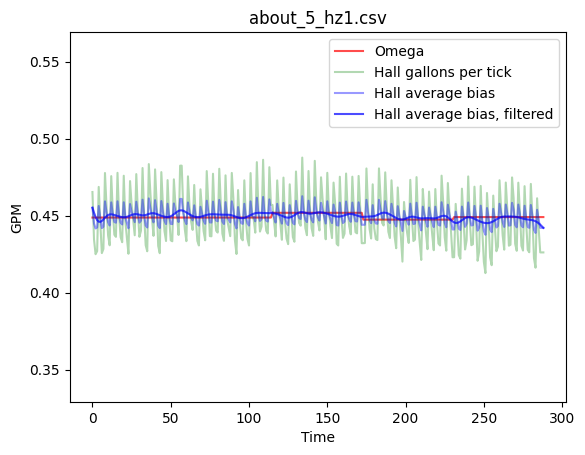

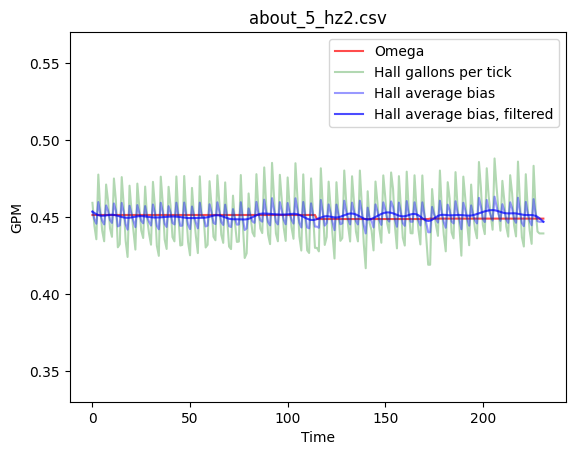

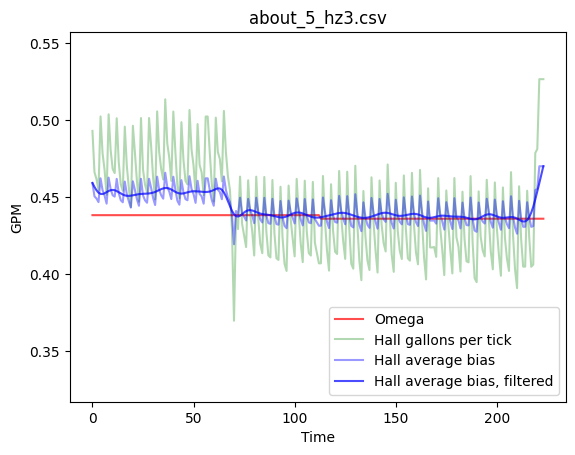

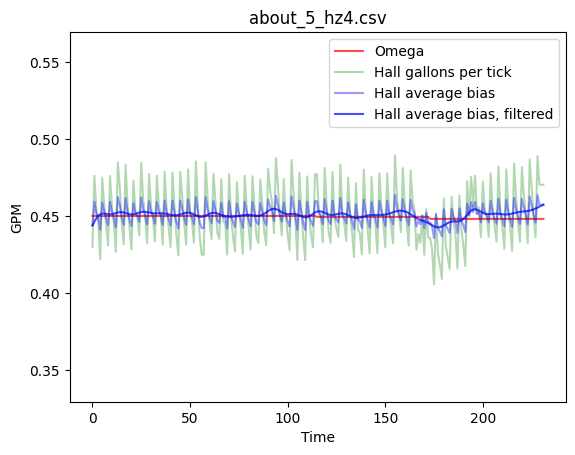

**************************************************
Frequency: 11 Hz
**************************************************


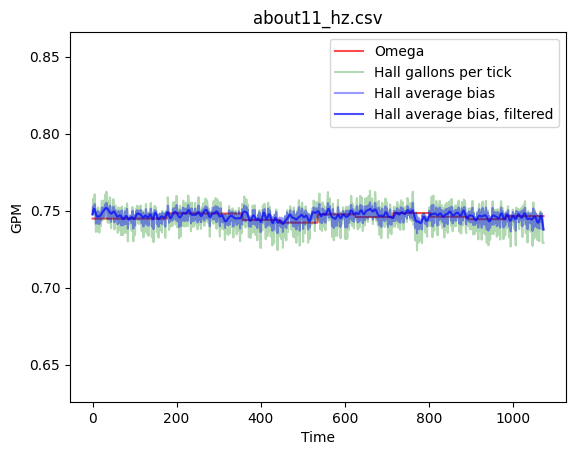

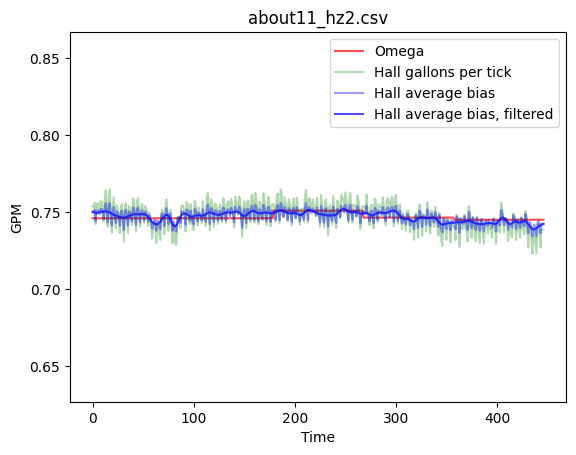

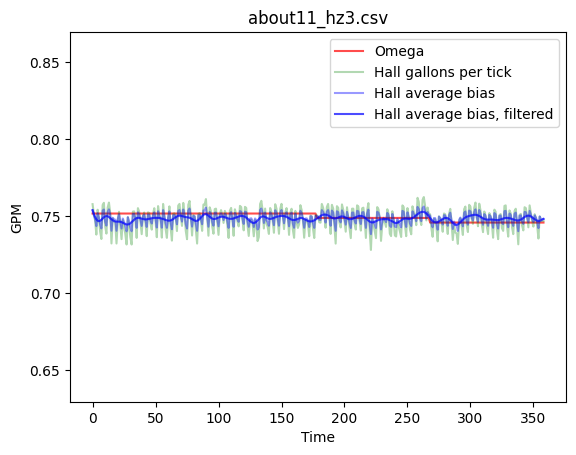

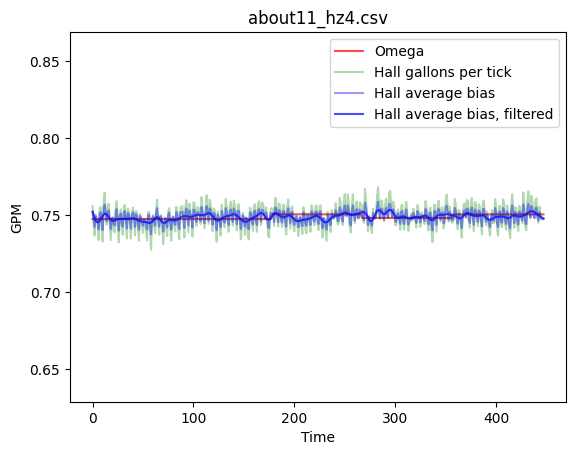

**************************************************
Frequency: 20 Hz
**************************************************


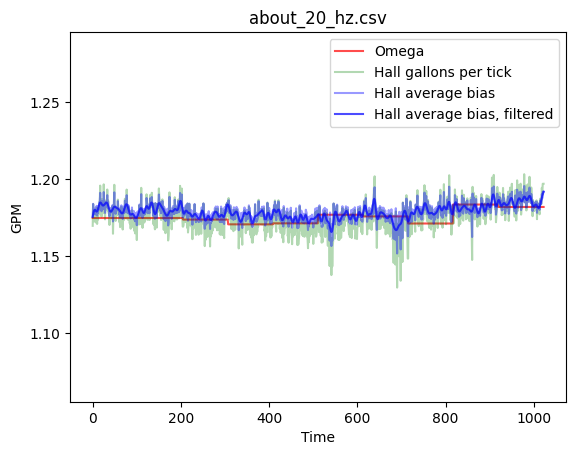

Dropped one row.


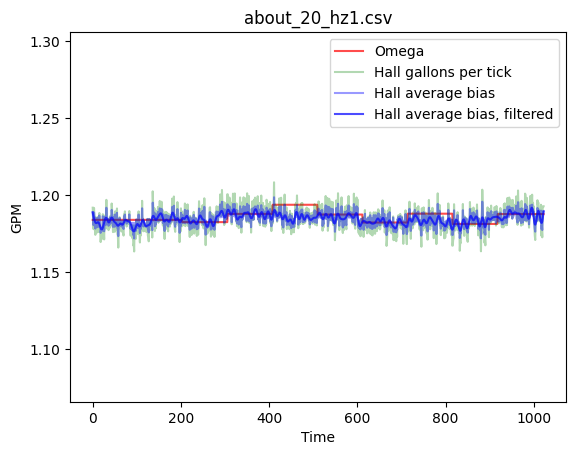

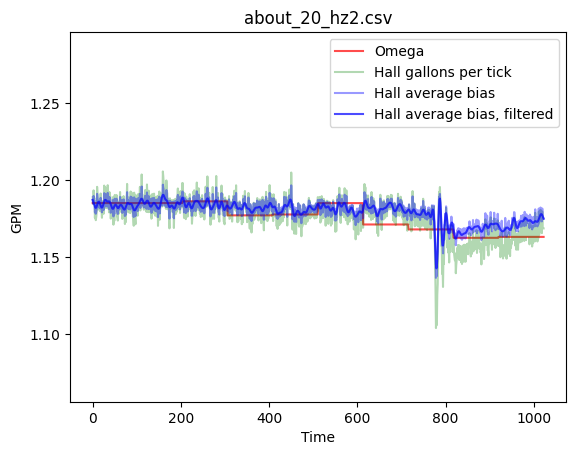

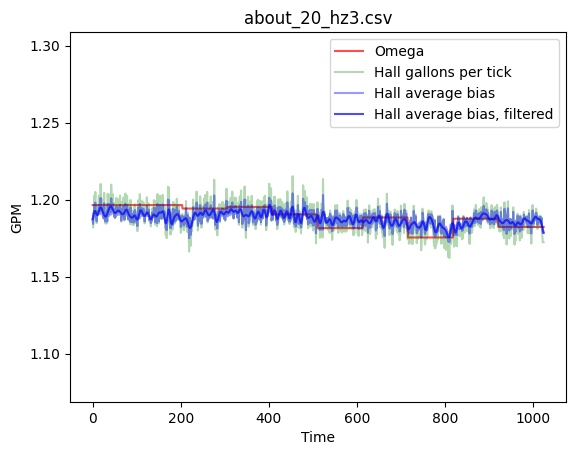

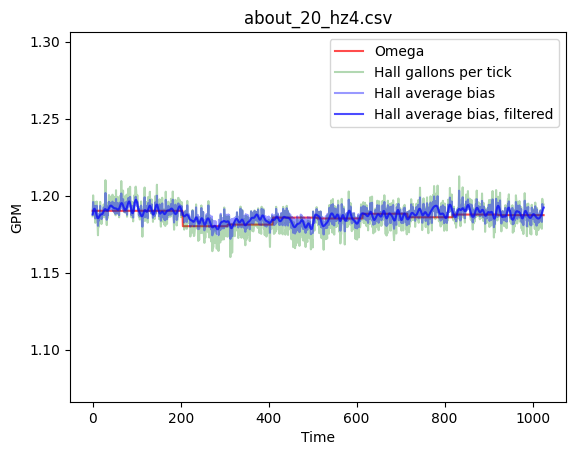

**************************************************
Frequency: 30 Hz
**************************************************


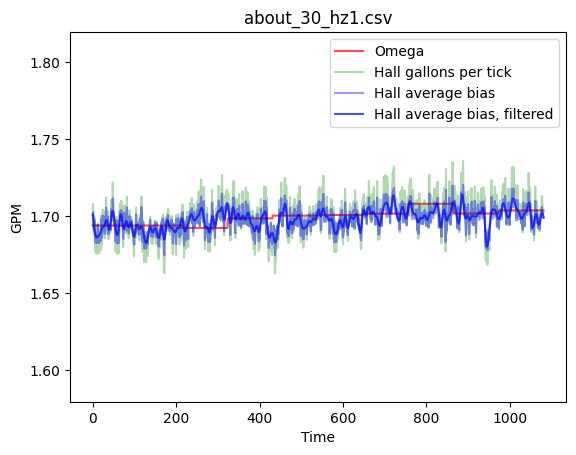

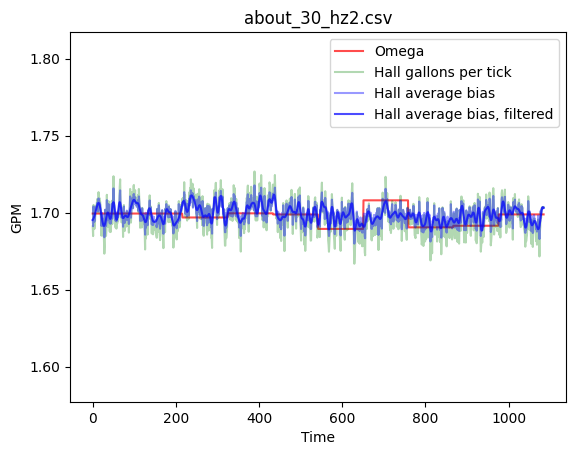

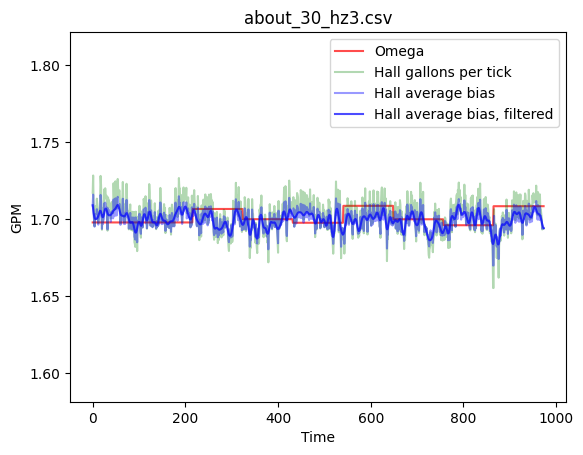

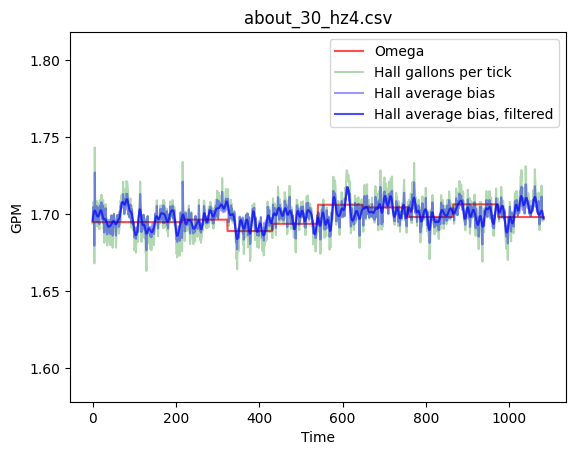

**************************************************
Frequency: 40 Hz
**************************************************


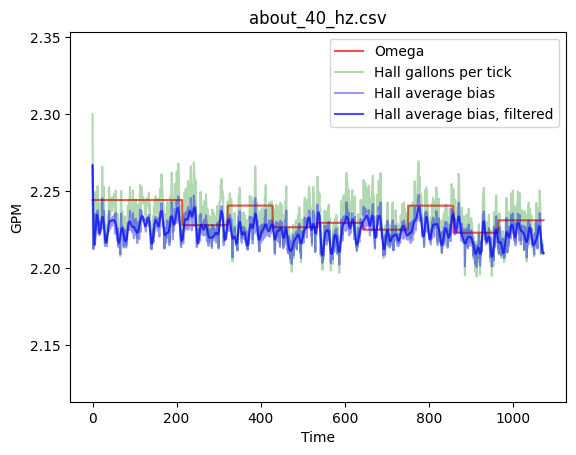

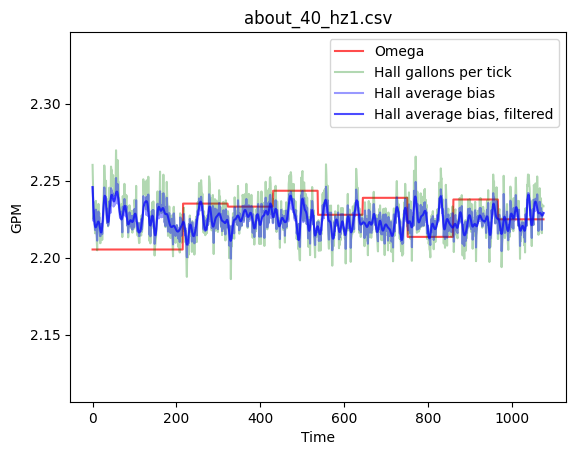

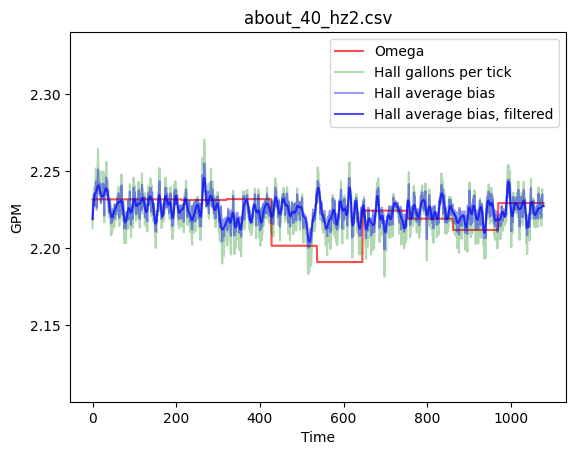

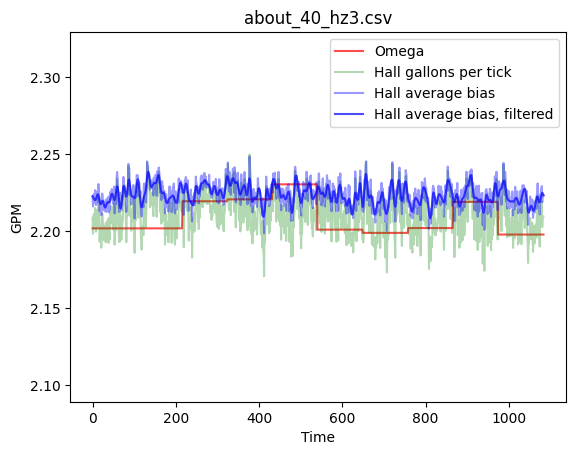

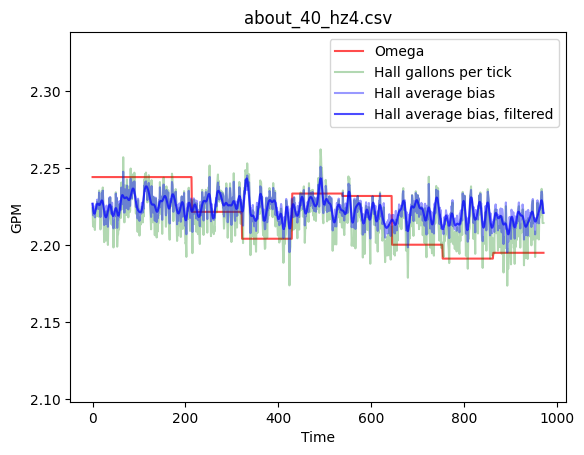

**************************************************
Frequency: 50 Hz
**************************************************


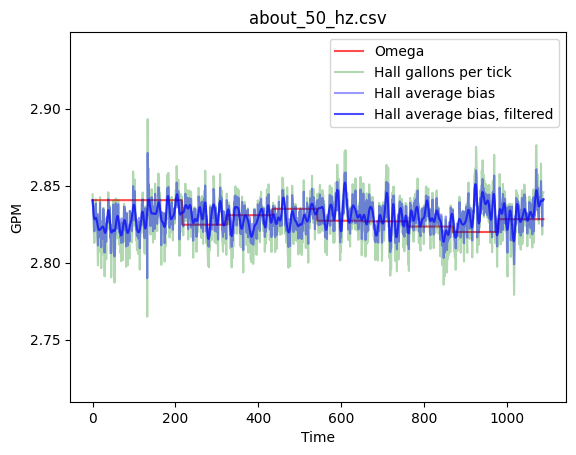

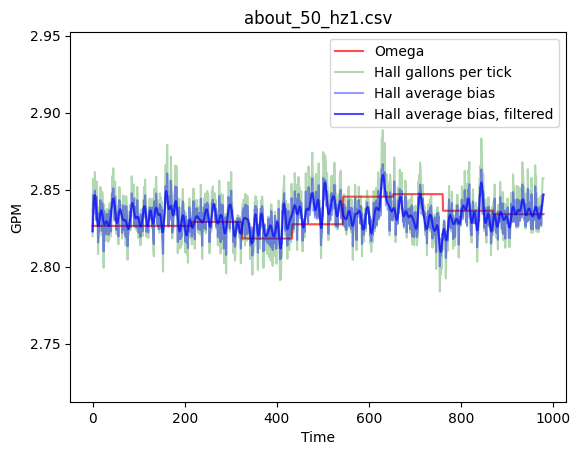

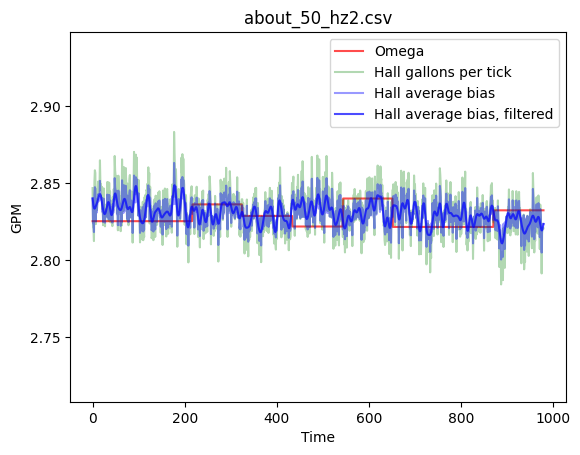

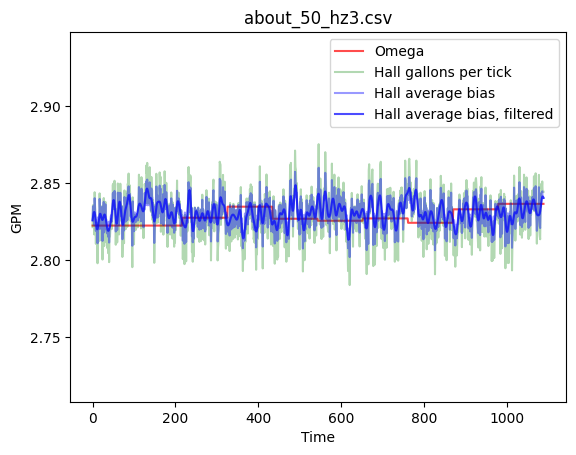

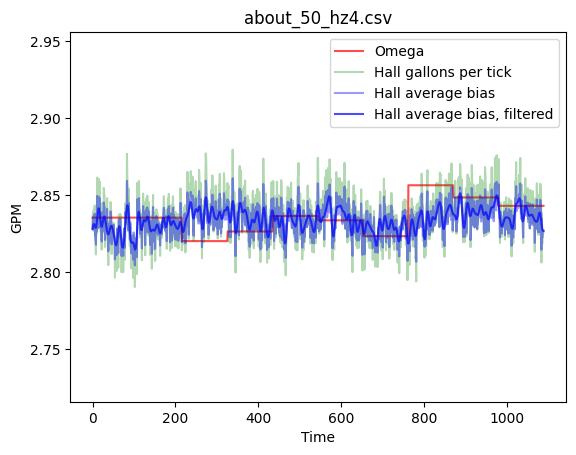

**************************************************
Frequency: 60 Hz
**************************************************


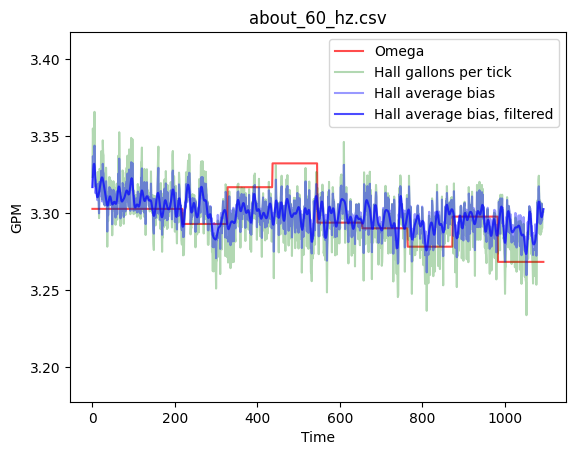

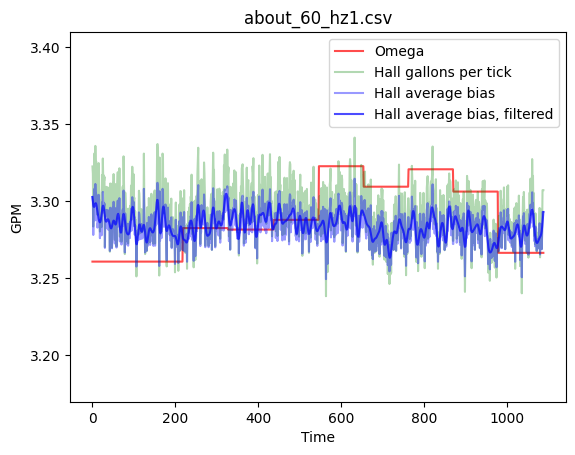

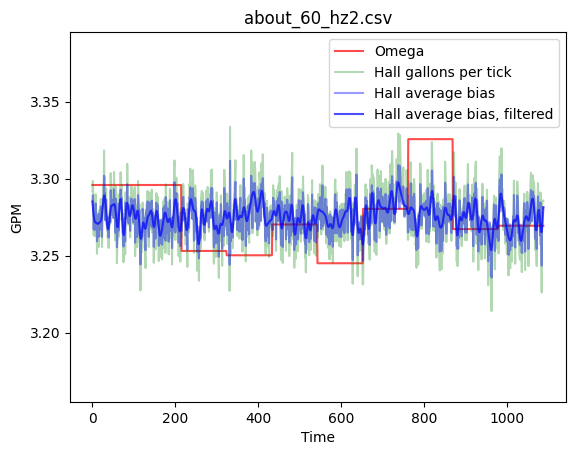

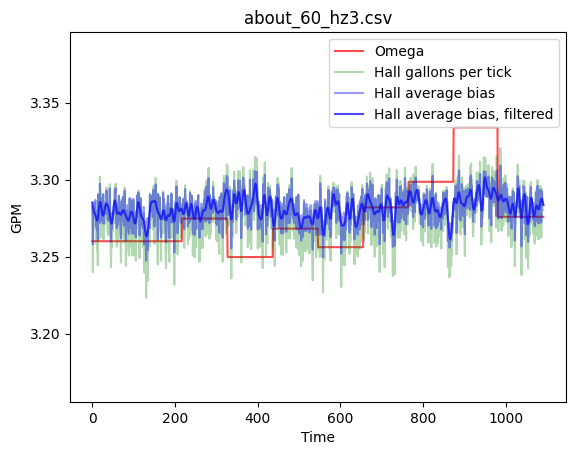

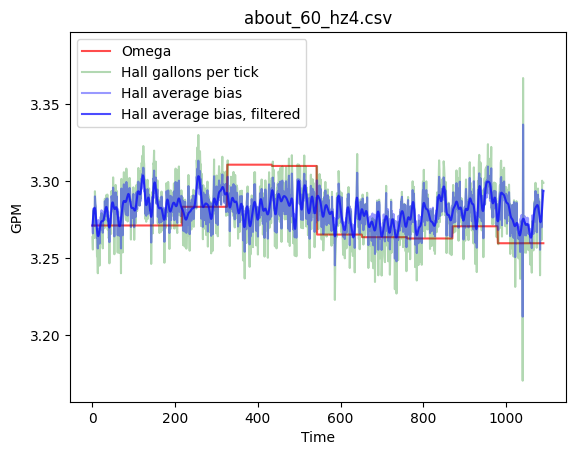

In [5]:
freqs = [5,11,20,30,40,50,60]
for f in freqs:
    print('*'*50)
    print(f'Frequency: {f} Hz')
    print('*'*50)
    for i in range(5):
        try:
            if i>0:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz{i}.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz{i}.csv')
            elif f!=30:
                if f!=11:
                    analyse(f'flow_data/about_{f}/about_{f}_hz.csv')
                else:   
                    analyse(f'flow_data/about_{f}/about{f}_hz.csv')
        except:
            continue

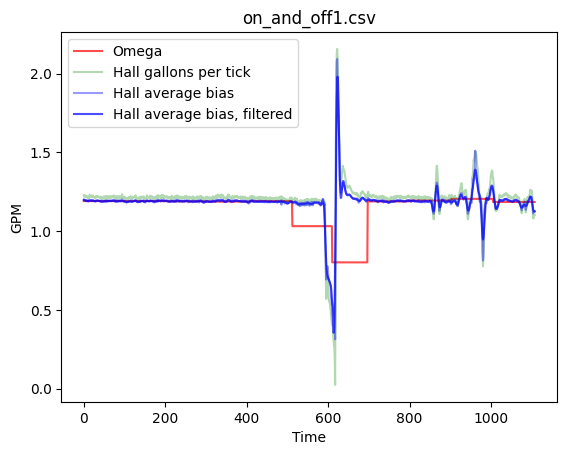

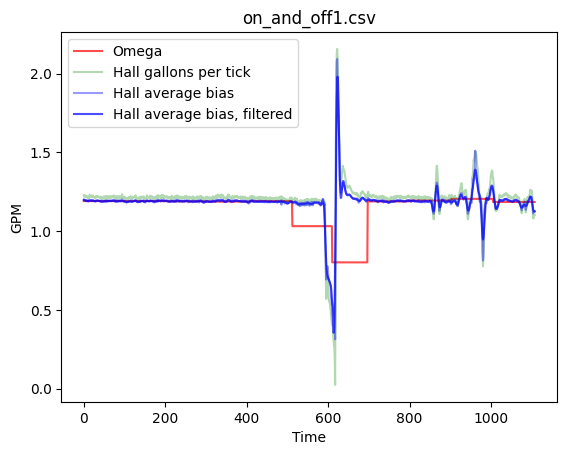

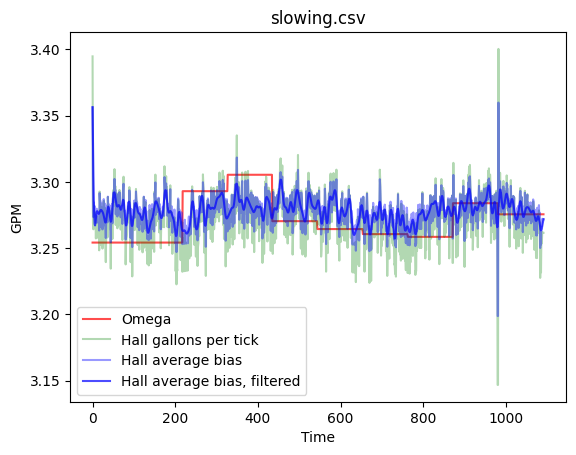

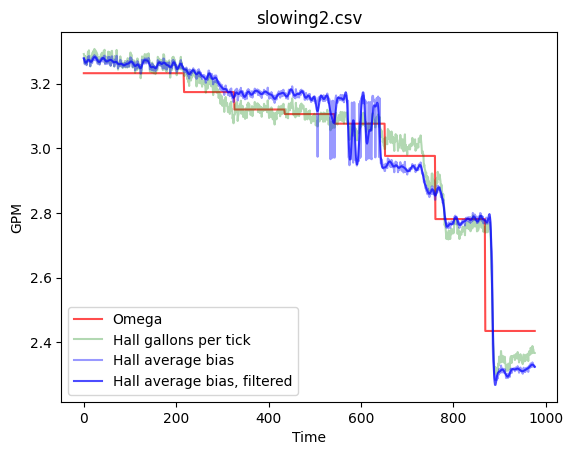

In [6]:
analyse('flow_data/onoff_slow/on_and_off1.csv', nolimit=True)
analyse('flow_data/onoff_slow/on_and_off1.csv', nolimit=True)
analyse('flow_data/onoff_slow/slowing.csv', nolimit=True)
analyse('flow_data/onoff_slow/slowing2.csv', nolimit=True)